In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[0])

import jax.numpy as jnp
from KernelTools import make_block,eval_k,vectorize_kfunc,diagpart,get_selected_grad
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel
from data_utils import build_xy_grid
from darcy_data import get_darcy_solver,sample_gp_function
from jax.random import PRNGKey as pkey
import matplotlib.pyplot as plt
from EquationModel import CholInducedRKHS,SharedOperatorPDEModel,InducedOperatorModel
from tqdm.auto import tqdm
from parabolic_data_utils import build_alpha_chebyshev
from data_utils import make_grids

In [2]:
num_functions = 50
samples_per_function = 10
collocation_grid_n = 25

obs_random_keys = jax.random.split(pkey(32),num_functions)
xy_obs = tuple(jax.random.uniform(key,(samples_per_function,2),minval = 0.,maxval = 1.) for key in obs_random_keys)


kernel_f = get_gaussianRBF(0.15)
key = pkey(10)
keys = jax.random.split(key,num_functions)
rhs_functions = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in keys
)

grid = jnp.linspace(0,1,100)
x,y = jnp.meshgrid(grid,grid)
fine_grid = jnp.vstack([x.flatten(),y.flatten()]).T

def a(x):
    return 0.1 * jnp.exp(0.5 * jnp.sin(4*jnp.pi*x[0]*x[1]))

darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.2))
u_true_functions = tuple([darcy_solve(f) for f in rhs_functions])

k_u = get_gaussianRBF(0.2)

single_grid = build_alpha_chebyshev([0,1],collocation_grid_n,1.)
xy_int,xy_bdy = make_grids(single_grid,single_grid)

xy_all = jnp.vstack([xy_int,xy_bdy])


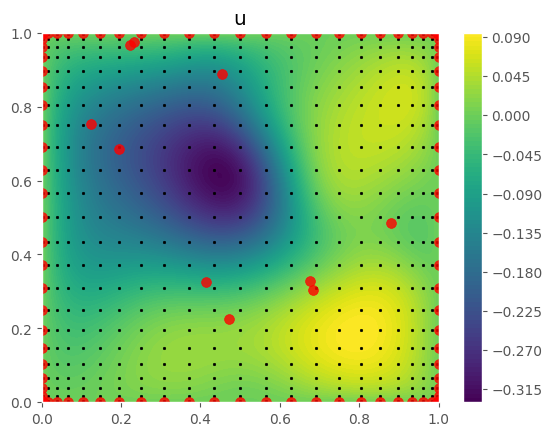

In [3]:
plt.title('u')
plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[0])(fine_grid),100)
plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 3)
plt.scatter(xy_obs[0][:,0],xy_obs[0][:,1],c = 'red',s = 50,alpha = 0.8)
plt.scatter(xy_bdy[:,0],xy_bdy[:,1],c = 'red',s = 50,alpha = 0.8)
plt.show()

In [4]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])
basis_operators = tuple([eval_k,diff_xx_op,diff_yy_op])

u_model = CholInducedRKHS(
    xy_all,
    basis_operators,
    k_u
)


observation_points = tuple(jnp.vstack([xy_bdy,obs]) for obs in xy_obs)
observation_values = tuple(jax.vmap(u)(obs_loc) for u,obs_loc in zip(u_true_functions,observation_points))
collocation_points = (xy_int,)*num_functions

rhs_values = tuple(jax.vmap(rhs_func)(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val) 
    for obs_loc,obs_val in zip(observation_points,observation_values)
    ]
    )

grid_features_u_init = [(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model_params in all_u_params_init
        ]
grid_features_u_init = jnp.vstack([jnp.hstack([xy_int,features]) for features in grid_features_u_init])

num_P_inducing = 250
input_feature_sample = jax.random.choice(pkey(320),grid_features_u_init,(num_P_inducing,))
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.25)
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

P_model = InducedOperatorModel(input_feature_sample,k_P)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

In [5]:
params_init = jnp.hstack(list(all_u_params_init)+[P_init])

u_init = jnp.stack(all_u_params_init)
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 10.,
    num_P_operator_params=num_P_inducing
)
beta_reg = 1e-12

In [6]:
from Optimizers import CholeskyLM,BlockArrowLM,AlternatingLM,AndersonAlternatingLM,run_jaxopt
from Optimizers import LMParams,AltLMParams,AndersonAltLMParams
from jaxopt import LBFGS

In [7]:
def loss_fun(params):
    return EqnModel.loss(params) + (beta_reg/2)*jnp.sum(params**2)

jit_valgrad = jax.jit(jax.value_and_grad(loss_fun))
lbfgs = LBFGS(fun=jit_valgrad,value_and_grad = True, maxiter=10000,tol = 1e-6,history_size = 40)
lbfgs_sol,lbfgs_conv,state = run_jaxopt(lbfgs,params_init)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1)
arrow_u,arrow_P,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )

alternating_params = AltLMParams(max_iter=501,init_alpha=1e-1)
alt_u,alt_P,alt_conv = AlternatingLM(u_init,P_init,EqnModel,beta_reg,beta_reg,alternating_params)

anderson_alternating_params = AndersonAltLMParams(
    alpha =  1e-6,
    AA_params={
        'maxiter':501,
        'history_size':20
    }
    )
ander_u,ander_P,ander_conv,state = AndersonAlternatingLM(u_init,P_init,EqnModel,beta_reg,beta_reg,anderson_alternating_params)

2024-11-03 13:22:41.057626: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.90 = f64[50,529,625]{2,1,0} reduce(f64[50,529,625,2]{3,2,1,0} %broadcast.1643, f64[] %constant.11), dimensions={3}, to_apply=%region_14.338, metadata={op_name="jit(full_loss)/jit(main)/vmap(jit(single_eqn_features))/jit(evaluate_operators)/reduce_sum" source_file="/home/owlx/kernelequationlearning/keql_tools/Kernels.py" source_line=37}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-11-03 13:23:20.625454: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 40.567949035s
Co

  0%|          | 0/501 [00:00<?, ?it/s]

2024-11-03 13:32:40.706816: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below 33.36GiB (35825110606 bytes) by rematerialization; only reduced to 34.89GiB (37458772624 bytes), down from 35.09GiB (37677074368 bytes) originally
2024-11-03 13:32:51.146237: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 34.30GiB (rounded to 36831098624)requested by op 
2024-11-03 13:32:51.146960: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] ***_*_______________________________________________________________________________________________
E1103 13:32:51.146993 1907970 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 36831098624 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 36831098624 bytes.

: 

In [ ]:
convergence_results = {
    #'Cholesky LM': lm_conv,
    'lbfgs': lbfgs_conv,
    'Arrow LM': arrow_conv,
    "Alternating LM": alt_conv,
    "AA Alternating": ander_conv
}

(0.0, 10.0)

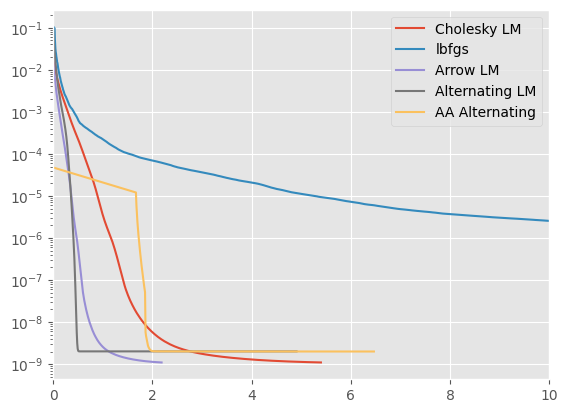

In [ ]:
for name,c in convergence_results.items():
    times = c.cumulative_time
    plt.plot(times[1:] - times[1],c.loss_vals[1:],label = name)
plt.legend()
plt.yscale('log')
plt.xlim(0,10)